# Objective: To assign patients beds effectively to minimize the waiting time

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.manual_seed(0)

# Steps:
1. Split the State in 2 parts S_in and S_out depending upon the threshold (U). 
2. S_in = data[<=U], S_out = data[>U] 
3. Initialize Lyapunov function
4. Baseline model
5. Exploration: Initiate model and estimate Lyapunov function 
6. Exploitation: Policy from Exploration will be used for S_in and for S_out a stable policy will be used.
7. Estimate model stability using Lyapunov function 

# Dummy dataset with some main features

In [2]:
# Generating random datetime values within a certain range
from datetime import datetime, timedelta
import random

N_obs = 2000


start_datetime = datetime(2023, 1, 1, 0, 0, 0)
end_datetime = datetime(2023, 1, 10, 23, 59, 59)


random_date_times = [
    start_datetime + timedelta(
        seconds=random.randint(0, int((end_datetime - start_datetime).total_seconds()))
    )
    for _ in range(N_obs)
]


Create a formula for processing time after bed is assigned.
Apply FCFS accordingly


In [3]:
Ndoctors = 25
MaxAclvl = 4
Nbeds = 35

state = pd.DataFrame({
    "Available Beds": np.random.randint(1, Nbeds+1, N_obs),
    # "Available Doctors": np.random.randint(1, Ndoctors+1, N_obs)

})

patients = pd.DataFrame(
    {
    "ArrivalTime": random_date_times,
    "Acuity_Lvl": np.random.randint(1, MaxAclvl+1, N_obs),
    "Age": [random.randint(1, 100) for _ in range(N_obs)],
    "Gender": [random.choice(["Male", "Female"]) for _ in range(N_obs)],
    }
)
patients['year'], patients["month"], patients['day'], patients['hour'], patients['minute'], patients['second'] = \
        patients["ArrivalTime"].dt.year, patients["ArrivalTime"].dt.month, patients["ArrivalTime"].dt.day, patients["ArrivalTime"].dt.hour, patients["ArrivalTime"].dt.minute, patients["ArrivalTime"].dt.second

acuity_weights = {
        1: 0.5,
        2: 0.75,
        3: 1.0,
        4: 1.25,
        5: 1.5,
    }

def calculate_end_time(row):
    acuity_weight = acuity_weights[row["Acuity_Lvl"]]
    occupancy_time = pd.Timedelta(hours=row["Acuity_Lvl"] * acuity_weight)
    return row["ArrivalTime"] + occupancy_time

# Calculate and add the end time
patients["OccupancyTime"] = patients.apply(calculate_end_time, axis=1)


# patients.sort_values(by="ArrivalTime")
patients.sample(5)

,ArrivalTime,Acuity_Lvl,Age,Gender,year,month,day,hour,minute,second,OccupancyTime
0,2023-01-08 10:32:03,2,47,Female,2023,1,8,10,32,3,2023-01-08 12:02:03
1504,2023-01-04 10:07:23,1,79,Female,2023,1,4,10,7,23,2023-01-04 10:37:23
787,2023-01-02 00:44:27,4,11,Female,2023,1,2,0,44,27,2023-01-02 05:44:27
1142,2023-01-06 01:35:14,3,18,Male,2023,1,6,1,35,14,2023-01-06 04:35:14
751,2023-01-05 10:06:48,2,41,Male,2023,1,5,10,6,48,2023-01-05 11:36:48


# Dispacthing rules (Baseline policies)

## First Come First Serve

Scheduling acc: ArrivalTime
Queue length: 15
Batch Size: 30


Average Wait Time: 5993.6245875
--------------------------------------------------------------------------------
Scheduling acc: ['Acuity_Lvl', 'ArrivalTime']
Queue length: 15
Batch Size: 30
Average Wait Time: 4116.08894375


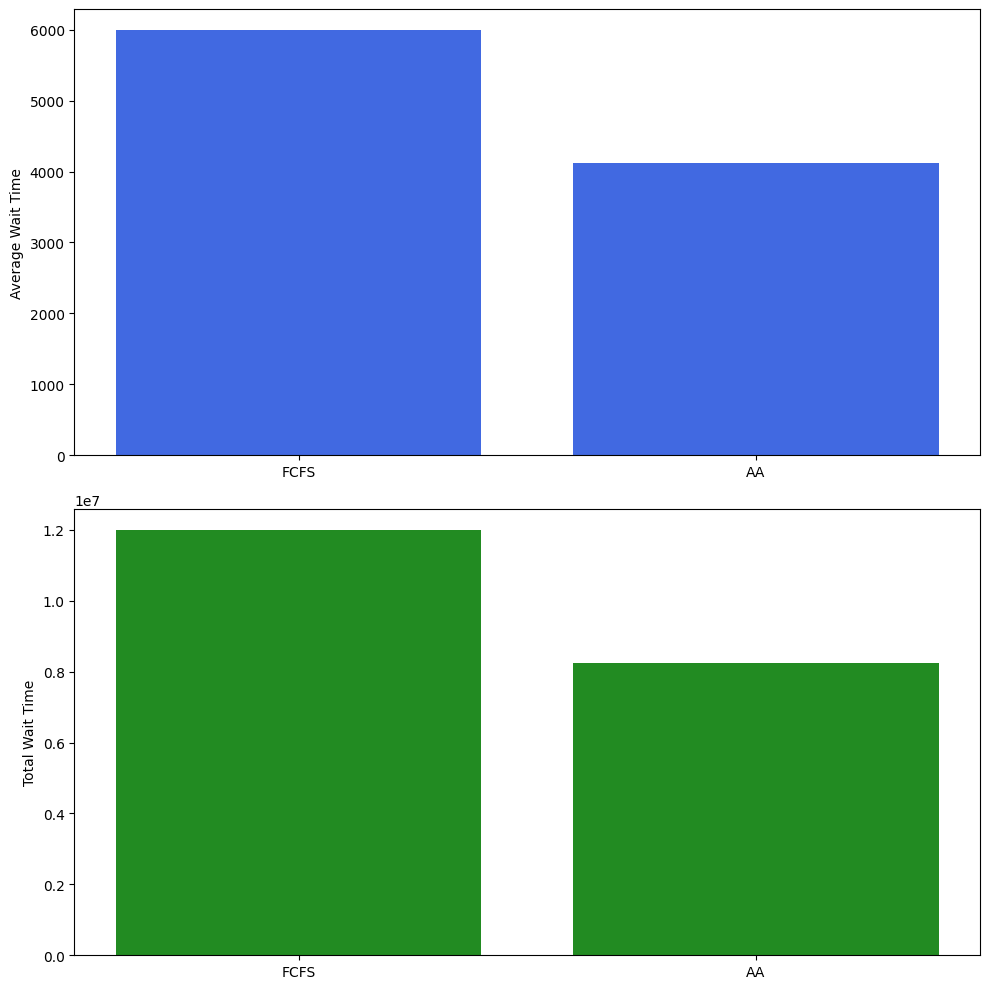

In [4]:
mean_minutes_acuity_1 = patients[patients['Acuity_Lvl'] == 1]['OccupancyTime'].dt.minute.mean()
mean_minutes_acuity_2 = patients[patients['Acuity_Lvl'] == 2]['OccupancyTime'].dt.minute.mean()

def scheduler(df, criterion="ArrivalTime", BATCH_SIZE=20, NBeds=10):
    NBeds = NBeds
    BATCH_SIZE = BATCH_SIZE
    print("Scheduling acc:", criterion)
    org = df.copy()
    if "Age" in criterion or "Acuity_Lvl" in criterion:
        queue = df.sort_values(by=criterion[:-1], ascending=False).iloc[:NBeds].copy()   
    
    queue = df.sort_values(by=criterion).iloc[:NBeds].copy()
    df = df.iloc[NBeds:]

    print("Queue length:", queue.shape[0])
    print("Batch Size:", BATCH_SIZE)

    wait_times = [0 for i in range(NBeds)]
    penalty_1, penalty_2 = 0, 0

    for start in range(0, len(patients), BATCH_SIZE):
        end = min(start + BATCH_SIZE, len(patients))
        batch = df[start:end].copy()
        if "Age" in criterion or "Acuity_Lvl" in criterion:
            batch = batch.sort_values(criterion[:-1], ascending=False)
        batch = batch.sort_values(criterion)
        while not batch.empty:
            entry_patient = batch.iloc[0]
            arrival_time = entry_patient["ArrivalTime"]
            acuity_level = entry_patient["Acuity_Lvl"]
            
            wait_time = acuity_weights[acuity_level] * (abs(arrival_time - queue.iloc[0]["OccupancyTime"])).total_seconds() / 60
            if wait_time > (60 + mean_minutes_acuity_1) and acuity_level == 1: # Add occupancy avg time for the acuity lvl
                penalty_1 += 1
            elif wait_time > (180 + mean_minutes_acuity_2) and acuity_level == 2:
                penalty_2 += 1
            wait_times.append(wait_time)
            
            queue = queue.iloc[1:].copy()  # Remove the front patient from the queue
            queue = pd.concat([queue, entry_patient.to_frame().T], ignore_index=True, sort=False)
            batch = batch.iloc[1:].copy()  # Remove the processed patient from the batch
    org['wait_times'] = wait_times
    Percent_penalty_1 = abs(penalty_1 - len(patients[patients['Acuity_Lvl'] == 1]))/100
    Percent_penalty_2 = abs(penalty_2 - len(patients[patients['Acuity_Lvl'] == 2]))/100

    return np.mean(wait_times), np.sum(wait_times), np.max(wait_times), np.min(wait_times), df, Percent_penalty_1, Percent_penalty_2
avg_fcfs, total_fcfs, maximum_fcfs, minimum_fcfs, fcfs_df, per_penalty1_fcfs, per_penalty2_fcfs = scheduler(patients, "ArrivalTime", BATCH_SIZE=30, NBeds=15)
print("Average Wait Time:", avg_fcfs)
# print("Sum Wait Time:", total_fcfs)
# print("Maximum Wait Time:", maximum_fcfs)
# print("Minimum Wait Time:", minimum_fcfs)

print("----"*20)
avg_aat, total_aat, maximum_aat, minimum_aat, df_aat, per_penalty1_aat, per_penalty2_aat = scheduler(patients, ["Acuity_Lvl", "ArrivalTime"], BATCH_SIZE=30, NBeds=15)
print("Average Wait Time:", avg_aat)
# print("Sum Wait Time:", total_aat)
# print("Maximum Wait Time:", maximum_aat)
# print("Minimum Wait Time:", minimum_aat)

# print("----"*20)
# avg_aaat, total_aaat, maximum_aaat, minimum_aaat, df_aaat, per_penalty1_aaat, per_penalty2_aaat = scheduler(patients, ["Acuity_Lvl", "Age", "ArrivalTime"], BATCH_SIZE=30, NBeds=15)
# print("Average Wait Time:", avg_aaat)
# print("Sum Wait Time:", total_aaat)
# print("Maximum Wait Time:", maximum_aaat)
# print("Minimum Wait Time:", minimum_aaat)


import pandas as pd

# Create DataFrames for each scheduling method with penalties
data_fcfs = {
    "Method": "FCFS",
    "Weighted Avg Waiting Time": avg_fcfs,
    # "Total Wait Time": total_fcfs,
    # "Maximum Wait Time": maximum_fcfs,
    # "Minimum Wait Time": minimum_fcfs,
    # "Penalty 1": per_penalty1_fcfs,
    # "Penalty 2": per_penalty2_fcfs,
    "Penalty": (per_penalty1_fcfs+per_penalty2_fcfs)/2
}

data_aat = {
    "Method": "AA",
    "Weighted Avg Waiting Time": avg_aat,
    # "Total Wait Time": total_aat,
    # "Maximum Wait Time": maximum_aat,
    # "Minimum Wait Time": minimum_aat,
    # "Penalty 1": per_penalty1_aat,
    # "Penalty 2": per_penalty2_aat,
    "Penalty": (per_penalty1_aat+per_penalty2_aat)/2
}

# data_aaat = {
#     "Method": "Acuity + Age + ArrivalTime",
#     "Average Wait Time": avg_aaat,
#     "Total Wait Time": total_aaat,
#     "Maximum Wait Time": maximum_aaat,
#     "Minimum Wait Time": minimum_aaat,
#     "Penalty 1": per_penalty1_aaat,
#     "Penalty 2": per_penalty2_aaat,
# }

df_fcfs = pd.DataFrame(data_fcfs, index=[0])
df_aat = pd.DataFrame(data_aat, index=[0])
# df_aaat = pd.DataFrame(data_aaat, index=[0])

# Concatenate the DataFrames
result_df = pd.concat([df_fcfs, df_aat], ignore_index=True)

methods = ["FCFS", "AA"]
average_wait_times = [avg_fcfs, avg_aat]
total_wait_times = [total_fcfs, total_aat]
maximum_wait_times = [maximum_fcfs, maximum_aat]
minimum_wait_times = [minimum_fcfs, minimum_aat]

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Create comparison plots
ax1.bar(methods, average_wait_times, color='royalblue')
ax1.set_ylabel('Average Wait Time')

ax2.bar(methods, total_wait_times, color='forestgreen')
ax2.set_ylabel('Total Wait Time')

# Save or show the plots
plt.tight_layout()
plt.show()

In [5]:
result_df

,Method,Weighted Avg Waiting Time,Penalty
0,FCFS,5993.624588,0.035
1,AA,4116.088944,0.185


In [6]:
from sklearn.preprocessing import LabelEncoder

for col in ["Gender"]:
    patients[col] = LabelEncoder().fit_transform(patients[col])

data = patients.drop(["ArrivalTime", "OccupancyTime"], axis=1)
data_cols = data.columns
data = torch.tensor(data.to_numpy(), dtype=torch.float32)

#### Handling Unboundedness using U (Size) thresholding

In [7]:
U = int(data.shape[0] * 0.6)
S_in = data[:U]
S_out = data[U:-1]
X_test = data[-1]

# Deep Q Learning model

### Agent

# Pretraining model inference

In [8]:
# patients[patients.ArrivalTime == patients.ArrivalTime.min()]
# patients

### Deep Reinforcement Learning module

In [9]:
pd.DataFrame(S_in, columns = [patients.columns[1:-1]]).to_csv( "S_in.csv", index=False)

pd.read_csv("S_in.csv")

,Acuity_Lvl,Age,Gender,year,month,day,hour,minute,second
0,2.0,47.0,0.0,2023.0,1.0,8.0,10.0,32.0,3.0
1,3.0,4.0,1.0,2023.0,1.0,7.0,8.0,51.0,22.0
2,2.0,85.0,1.0,2023.0,1.0,9.0,14.0,42.0,13.0
3,3.0,46.0,1.0,2023.0,1.0,2.0,12.0,4.0,5.0
4,4.0,12.0,1.0,2023.0,1.0,10.0,15.0,4.0,11.0
...,...,...,...,...,...,...,...,...,...
1195,3.0,52.0,1.0,2023.0,1.0,10.0,7.0,36.0,58.0
1196,2.0,46.0,0.0,2023.0,1.0,2.0,14.0,30.0,38.0
1197,1.0,51.0,0.0,2023.0,1.0,7.0,19.0,46.0,1.0
1198,3.0,7.0,1.0,2023.0,1.0,6.0,10.0,48.0,50.0


In [10]:
import random
import numpy as np
import torch
from tqdm import trange
import torch.nn as nn
import torch.optim as optim
import gym

from tqdm.autonotebook import tqdm

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, action_dim),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.network(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, gamma=0.99, learning_rate=0.001):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.gamma = gamma
        self.q_network = DQN(state_dim, action_dim).to(device)
        self.target_network = DQN(state_dim, action_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.HuberLoss()

    def select_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            with torch.no_grad():
                q_values = self.q_network(state)
                return q_values.argmax().item()

    def train(self, state, action, next_state, reward, done):
        q_values = self.q_network(state.to(device))
        next_q_values = self.target_network(next_state.to(device))
        target = q_values.clone()
        if done:
            target[0][action] = reward
        else:
            target[0][action] = reward + self.gamma * next_q_values.max().item()

        loss = self.loss_fn(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())


class PatientSchedulingEnv(gym.Env):
    def __init__(self, dataset):
        super(PatientSchedulingEnv, self).__init__()
        self.dataset = dataset
        self.state_dim = dataset.shape[0] - 1  # Exclude the 'Action' column
        self.action_dim = 2
        self.current_index = 0

    def reset(self):
        self.current_index = 0
        return self.get_state()

    def step(self, action):
        if action not in [0, 1]:
            raise ValueError("Invalid action")

        next_state = self.get_state()
        reward = self.calculate_reward(action)
        done = self.current_index >= len(self.dataset) - 1
        info = {}

        self.current_index += 1

        return next_state, reward, done, info

    def get_state(self):
        return self.dataset[self.current_index, :-1]  # Exclude the 'Action' column

    def calculate_reward(self, action):
        acuity_level = self.dataset[self.current_index, 0]
        age = self.dataset[self.current_index, 1]
        gender = self.dataset[self.current_index, 2]
        if action == 0: # Modifications needed
            reward = (acuity_level * 0.8 + age * 0.15 + gender * 0.05) 
        else:
            reward = (-acuity_level * 0.8 + age * 0.15 + gender * 0.05)

        return reward

state_dim = S_in.shape[1] - 1
action_dim = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
agent = DQNAgent(state_dim, action_dim)
env = PatientSchedulingEnv(S_in )
num_episodes = 500
rewards = []

with trange(num_episodes, desc='Episodes', position=0, leave=True) as progress_bar:
    for episode in progress_bar:
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = state.unsqueeze(0).clone().detach()
            action = agent.select_action(state_tensor.to(device))
            next_state, reward, done, _ = env.step(action)
            agent.train(state_tensor, action, next_state.clone().detach().unsqueeze(0), reward, done)
            state = next_state
            total_reward += reward

        agent.update_target_network()

        rewards.append(total_reward)
        progress_bar.set_postfix(TotalReward=total_reward.item())
    

plt.plot(rewards)
plt.show()

C:\Users\Ali & Alifia's Home\AppData\Local\Temp\ipykernel_15416\3693845083.py:9: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Episodes:   0%|          | 0/500 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [17]:
min(rewards), max(rewards)

(tensor(10970.3936), tensor(11384.7969))

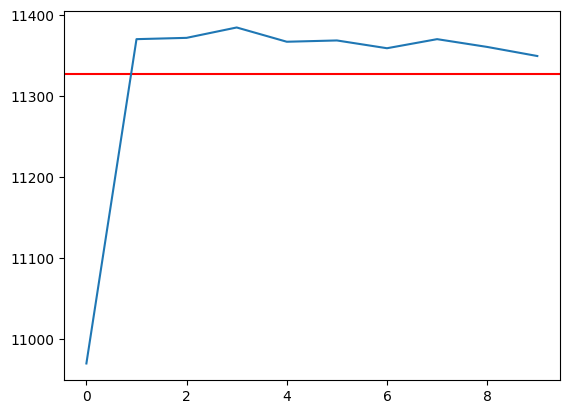

In [18]:
# Checking the last 300 rewards
plt.axhline(np.mean(rewards), color='r', linestyle='-')
plt.plot(rewards[-300:]);

# New approach

In [32]:
import random
from annotated_types import T
import numpy as np
import torch
from tqdm import trange
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
from collections import namedtuple, deque

from tqdm.autonotebook import tqdm

# Define the neural network architecture
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, action_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

# Define the replay memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity, window_size):
        self.capacity = capacity
        self.window_size = window_size
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        if len(self.memory) < batch_size:
            return []  # Not enough samples in the replay memory

        start_index = random.randint(0, len(self.memory) - batch_size)
        return list(self.memory)[start_index:start_index + batch_size]


class DQNAgent:
    def __init__(self, state_dim, action_dim, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, gamma=0.99, learning_rate=0.001, replay_capacity=10000, batch_size=64):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.gamma = gamma
        self.q_network = DQN(state_dim, action_dim).to(device)
        self.target_network = DQN(state_dim, action_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=2, T_mult=5, eta_min=0.002)
        self.loss_fn = nn.HuberLoss()
        self.replay_memory = ReplayMemory(replay_capacity, window_size)
        self.batch_size = batch_size

    def select_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            with torch.no_grad():
                q_values = self.q_network(state)
                return q_values.argmax().item()

    def train(self):
        if len(self.replay_memory.memory) < self.batch_size:
            return  # Not enough samples in the replay memory

        transitions = self.replay_memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.cat(batch.state)
        action_batch = torch.tensor(batch.action).unsqueeze(1).to(device)
        next_state_batch = torch.cat(batch.next_state)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
        done_batch = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

        q_values = self.q_network(state_batch)
        next_q_values = self.target_network(next_state_batch)

        target = q_values.clone()
        target[torch.arange(self.batch_size), action_batch.squeeze()] = (reward_batch + (1 - done_batch) * self.gamma * next_q_values.max(dim=1, keepdim=True).values[:, 0]).squeeze()

        loss = self.loss_fn(q_values, target.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

        return loss 

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())
class PatientSchedulingEnv(gym.Env):
    def __init__(self, dataset, window_size):
        super(PatientSchedulingEnv, self).__init__()
        self.dataset = dataset
        self.state_dim = (window_size, dataset.shape[1] - 1)
        self.action_dim = 2
        self.window_size = window_size
        self.current_index = 0

    def reset(self):
        self.current_index = 0
        return self.get_state()

    def step(self, action):
        if action not in [0, 1]:
            print(action)
            raise ValueError("Invalid action")

        next_state = self.get_state()
        reward, waiting_times = self.calculate_reward(action)
        done = self.current_index >= len(self.dataset) - 1  # Consider episode as done at the end of the dataset
        info = {}

        if not done:
            self.current_index += 1

        return next_state, reward, done, info, waiting_times

    def get_state(self):
        window_data = self.dataset[self.current_index:min(self.current_index + self.window_size, len(self.dataset)), 1:]
        padding_size = max(0, self.window_size - len(window_data))
        padded_data = np.pad(window_data, ((0, padding_size), (0, 0)), 'constant', constant_values=0)
        return torch.tensor(padded_data, dtype=torch.float32).unsqueeze(0).to(device)


    def calculate_reward(self, action):
        current_acuity = self.dataset[self.current_index, 0]
        future_acuity = self.dataset[self.current_index + 1:, 0]
        waiting_times = []

        if len(future_acuity) == 0:
            reward = -0.1
        else:
            window_future_acuity = future_acuity[:self.window_size]
            higher_acuity_count = (window_future_acuity > current_acuity).sum()

            normalized_count = higher_acuity_count / (self.window_size + 1)  # Considering window size in normalization
            
            if action == 0:  # Reject
                if higher_acuity_count: # If higher acuity patient exists
                    # reward = 1 * normalized_count
                    reward = -1
                else:
                    # reward = -2 * normalized_count
                    reward = -100
            else:  # Accept
                if higher_acuity_count:
                    # reward = -2 * normalized_count
                    reward = -100
                else:
                    # reward = 1 * normalized_count
                    reward = -1

            # Calculate waiting time for each patient in the window
            for i in range(len(window_future_acuity)):
                # Calculate waiting time based on when the patient entered the system
                waiting_times.append(max(0, self.current_index + i + 1 - self.dataset[self.current_index + i + 1, -2]))

        return reward, waiting_times

# Assuming S_in is your dataset
device = "cuda" if torch.cuda.is_available() else "cpu"
window_size = 40 # Set your desired window size
agent = DQNAgent(state_dim=S_in.shape[1] - 1, action_dim=2, replay_capacity=10000, batch_size=64)
env = PatientSchedulingEnv(S_in, window_size)
num_episodes = 5
rewards = []
avg_waiting_times_list = []
losses = []

acuity_weights = {
    1: 0.5,
    2: 0.75,
    3: 1.0,
    4: 1.25,
    5: 1.5,
}
with trange(num_episodes, desc='Episodes', position=0, leave=True) as progress_bar:
    for episode in progress_bar:
        state = env.reset()
        total_reward = 0
        done = False
        waiting_times_list = []  # Reset waiting times for each episode

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _, waiting_times = env.step(action)
            agent.replay_memory.push(Transition(state, action, next_state, reward, done))
            agent.train()
            state = next_state
            total_reward += torch.tensor(reward, dtype=torch.long)
            waiting_times_list.extend(waiting_times)

        agent.update_target_network()
        if len(agent.replay_memory.memory) >= agent.batch_size:
            loss = agent.train()
            losses.append(float(loss.item()))

        rewards.append(total_reward)
        avg_waiting_time = np.mean([waiting_time * acuity_weights[acuity.item()] for waiting_time, acuity in zip(waiting_times_list, env.dataset[:len(waiting_times_list), 0])])

        avg_waiting_times_list.append(avg_waiting_time)
        progress_bar.set_postfix(TotalReward=total_reward.item(), AvgWaitingTime=avg_waiting_time, Loss=loss.item())

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='Total Reward')
plt.plot(avg_waiting_times_list, label='Avg Waiting Time')
plt.plot(losses, label='Loss')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Values')
plt.title('Total Reward and Average Waiting Time over Episodes')
plt.show()

Episodes:   0%|          | 0/5 [00:00<?, ?it/s]

Episodes:  40%|████      | 2/5 [00:26<00:39, 13.21s/it, AvgWaitingTime=12.1, Loss=1.71, TotalReward=-88517]

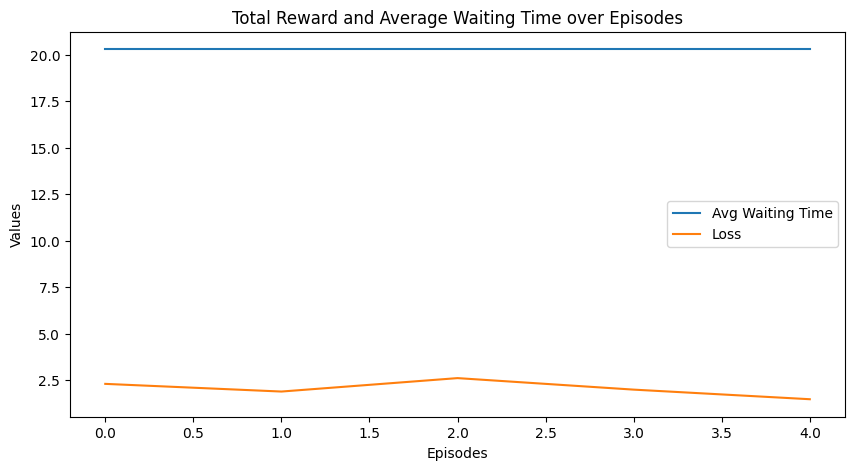

In [28]:
plt.figure(figsize=(10, 5))
# plt.plot(rewards, label='Total Reward')
plt.plot(avg_waiting_times_list, label='Avg Waiting Time')
plt.plot(losses, label='Loss')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Values')
plt.title('Total Reward and Average Waiting Time over Episodes')
plt.show()

# Reference
- https://github.com/edwardhdlu/q-trader

- https://github.com/backgom2357/Recommender_system_via_deep_RL

# Agent

In [13]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam

import numpy as np
import random
from collections import deque

class Agent:
	def __init__(self, state_size, is_eval=False, model_name=""):
		self.state_size = state_size # normalized previous days
		self.action_size = 2 # sit, buy, sell
		self.memory = deque(maxlen=1000)
		self.inventory = []
		self.model_name = model_name
		self.is_eval = is_eval

		self.gamma = 0.95
		self.epsilon = 1.0
		self.epsilon_min = 0.01
		self.epsilon_decay = 0.995

		self.model = load_model("models/" + model_name) if is_eval else self._model()

	def _model(self):
		model = Sequential()
		model.add(Dense(units=32, input_dim=self.state_size, activation="relu"))
		model.add(Dense(units=32, activation="relu"))
		model.add(Dense(units=8, activation="relu"))
		model.add(Dense(self.action_size, activation="linear"))
		model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))

		return model

	def act(self, state):
		if not self.is_eval and np.random.rand() <= self.epsilon:
			return random.randrange(self.action_size)

		options = self.model.predict(state)
		return np.argmax(options[0])

	def expReplay(self, batch_size):
		mini_batch = []
		l = len(self.memory)
		for i in range(l - batch_size + 1, l):
			mini_batch.append(self.memory[i])

		for state, action, reward, next_state, done in mini_batch:
			target = reward
			if not done:
				target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

			target_f = self.model.predict(state)
			target_f[0][action] = target
			self.model.fit(state, target_f, epochs=1, verbose=0)

		if self.epsilon > self.epsilon_min:
			self.epsilon *= self.epsilon_decay 


# Until functions

In [17]:
import numpy as np
import math

# prints formatted price
def formatPrice(n):
	return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns the vector containing stock data from a fixed file
def getStockDataVec(key):
	vec = []
	lines = open(r"" + key + ".csv", "r").read().splitlines()

	for line in lines[1:]:
		vec.append(float(line.split(",")[4]))

	return vec

# returns the sigmoid
def sigmoid(x):
	return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t
def getState(data, t, n):
	d = t - n + 1
	block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
	res = []
	for i in range(n - 1):
		res.append(sigmoid(block[i + 1] - block[i]))

	return np.array([res])


# Train

In [18]:
stock_name, window_size, episode_count = "S_in", 10, 2

agent = Agent(window_size)
data = getStockDataVec(stock_name)
l = len(data) - 1
batch_size = 100

for e in range(episode_count + 1):
	print ("Episode " + str(e) + "/" + str(episode_count))
	state = getState(data, 0, window_size + 1)

	total_profit = 0
	agent.inventory = []

	for t in range(l):
		action = agent.act(state)

		# sit
		next_state = getState(data, t + 1, window_size + 1)
		reward = 0

		if action == 1: # buy
			agent.inventory.append(data[t])
			print ("Buy: " + formatPrice(data[t]))

		elif action == 2 and len(agent.inventory) > 0: # sell
			bought_price = agent.inventory.pop(0)
			reward = max(data[t] - bought_price, 0)
			total_profit += data[t] - bought_price
			print ("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

		done = True if t == l - 1 else False
		agent.memory.append((state, action, reward, next_state, done))
		state = next_state

		if done:
			print ("--------------------------------")
			print ("Total Profit: " + formatPrice(total_profit))
			print ("--------------------------------")

		if len(agent.memory) > batch_size:
			agent.expReplay(batch_size)

	if e % 10 == 0:
		agent.model.save("models/model_ep" + str(e))


1/1 [==============================] - 0s 29ms/step


KeyboardInterrupt: 

References: